# Processing Doench 2014

Processing data from [Doench et al. 2014](https://www.nature.com/articles/nbt.3026)

### Data Filters
1. pdna or etp > mean pdna -3 std
2. match bin1, tier 1 score of 0

In [1]:
import pandas as pd
import poola.core as pool
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt

In [2]:
mouse_reads = pd.read_csv('../data/raw/Doench2014_mouse_reads.csv')
human_reads = pd.read_csv('../data/raw/Doench2014_human_reads.csv')

## Mouse Data

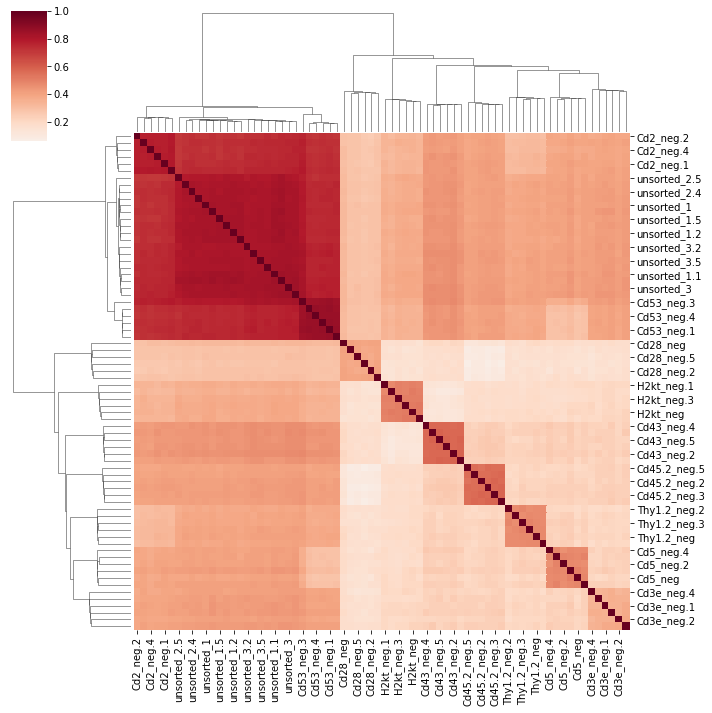

In [3]:
clean_mouse_reads = mouse_reads.copy()
clean_mouse_reads['sgRNA Sequence'] = clean_mouse_reads['sgRNA (21nts used for ID)'].str[0:20]
clean_mouse_reads = clean_mouse_reads.drop(['sgRNA (21nts used for ID)', 
                                            'Gene:Exon:Transcript:strand:count'], axis=1)
mouse_lognorms = pool.lognorm_columns(clean_mouse_reads, 
                                      clean_mouse_reads.columns[clean_mouse_reads.columns != 
                                                                'sgRNA Sequence'])
mouse_lognorm_cors = mouse_lognorms.corr()
sns.clustermap(mouse_lognorm_cors, cmap='RdBu_r', center=0)


In [4]:
mouse_long_lognorms = (mouse_lognorms.melt(id_vars='sgRNA Sequence', var_name='condition', 
                                           value_name='lognorm'))
mouse_long_lognorms['condition'] = mouse_long_lognorms['condition'].str.split('_', expand=True)[0]
mouse_avg_lognorms = (mouse_long_lognorms.groupby(['condition', 'sgRNA Sequence'])
                      .agg({'lognorm': 'mean'})
                      .reset_index())
mouse_spread_lognorms = (mouse_avg_lognorms.pivot_table(values='lognorm', index='sgRNA Sequence', 
                                                        columns='condition')
                         .reset_index())
mouse_filtered_lognorms = pool.filter_pdna(mouse_spread_lognorms, ['unsorted'])
mouse_lfcs = pool.calculate_lfcs(mouse_filtered_lognorms, ref_col='unsorted',
                                 target_cols = ['Cd2', 'Cd28', 'Cd3e', 'Cd43',
                                                'Cd45.2', 'Cd5', 'H2kt', 'Thy1.2'])
mouse_long_lfcs = (mouse_lfcs.melt(id_vars='sgRNA Sequence', var_name='condition', value_name='lfc'))

In [5]:
mouse_sg_list = list(mouse_lfcs['sgRNA Sequence'].unique())
mouse_design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_10090_GRCm38_SpyoCas9_CRISPRko_Ensembl_20200406.parquet',
                                  filters=[[('sgRNA Sequence', 'in', mouse_sg_list)]])

In [6]:
mouse_condition_map = {'Cd45.2': 'Ptprc',
                       'Cd43': 'Spn', 
                       'H2kt': 'H2-K1', 
                       'Thy1.2': 'Thy1'}
mouse_lfcs_designs = (mouse_long_lfcs
                      .merge(mouse_design_df, how = 'inner', on = 'sgRNA Sequence'))
mouse_lfcs_designs['condition'] = mouse_lfcs_designs['condition'].replace(mouse_condition_map)
mouse_lfcs_designs['neg_lfc'] = -mouse_lfcs_designs['lfc']
filtered_mouse_lfcs = mouse_lfcs_designs[mouse_lfcs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
mouse_genes = mouse_design_df['Target Gene Symbol'].unique()
for cond, df in filtered_mouse_lfcs.groupby('condition'):
    print(cond)
    roc_aucs = pool.get_roc_aucs(lfcs=df, tp_genes=[cond], 
                                 fp_genes=mouse_genes[mouse_genes != cond], 
                                 gene_col='Target Gene Symbol', 
                                 score_col='neg_lfc', group_col='condition')
    print(roc_aucs)

Cd2
  condition   ROC-AUC
0       Cd2  0.641208
Cd28
  condition   ROC-AUC
0      Cd28  0.970459
Cd3e
  condition   ROC-AUC
0      Cd3e  0.892106
Cd5
  condition   ROC-AUC
0       Cd5  0.914915
Cd53
  condition   ROC-AUC
0      Cd53  0.741403
H2-K1
  condition   ROC-AUC
0     H2-K1  0.931493
Ptprc
  condition   ROC-AUC
0     Ptprc  0.939674
Spn
  condition   ROC-AUC
0       Spn  0.976427
Thy1
  condition  ROC-AUC
0      Thy1  0.98841


In [7]:
mouse_conditions = ['Cd28', 'Cd3e', 'Cd5', 'H2-K1', 'Ptprc', 'Spn', 'Thy1']

In [8]:
mouse_model_df_list = []
for cond, df in filtered_mouse_lfcs.groupby('condition'):
    if cond in mouse_conditions:
        tp_sgs = df[df['Target Gene Symbol'] == cond].copy()
        tp_sgs['gene_rank'] = (tp_sgs
                           .lfc
                           .rank(pct=True, ascending=True))
        mouse_model_df_list.append(tp_sgs)
mouse_model_df = pd.concat(mouse_model_df_list)

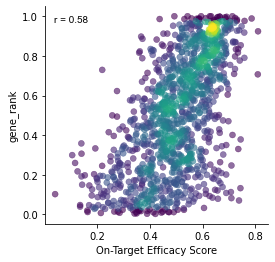

In [9]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=mouse_model_df, y='gene_rank', x='On-Target Efficacy Score')
gpplot.add_correlation(data=mouse_model_df, y='gene_rank', x='On-Target Efficacy Score')
sns.despine()

In [10]:
mouse_training_data = mouse_model_df[['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                      'Target Cut %', 'gene_rank']].copy()
mouse_training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,gene_rank
109,AAACAGTGACGTTCCGTCTC,AACGAAACAGTGACGTTCCGTCTCTGGAAT,Cd28,45.2,0.012658
199,AAAGCAGTCGCCCCTGCTTG,TGGTAAAGCAGTCGCCCCTGCTTGTGGTAG,Cd28,13.4,0.430380
244,AAAGTCTCTGGCAGGGGCGT,CTGCAAAGTCTCTGGCAGGGGCGTAGGGCT,Cd28,94.7,0.531646
370,AACATGACTCCCCGGAGGCC,CATGAACATGACTCCCCGGAGGCCTGGGCT,Cd28,89.3,0.050633
811,AAGTCTCTGGCAGGGGCGTA,TGCAAAGTCTCTGGCAGGGGCGTAGGGCTG,Cd28,94.5,0.658228
...,...,...,...,...,...
21662,TGCTGGTTCAGAACACATCC,AGCCTGCTGGTTCAGAACACATCCTGGATG,Thy1,86.5,0.432099
21887,TGGAGAGGGTGACGCGGGAG,TGGTTGGAGAGGGTGACGCGGGAGCGGTAC,Thy1,47.0,0.320988
22211,TGGTGAAGTTGGCTAGGGTA,TTGGTGGTGAAGTTGGCTAGGGTAAGGACC,Thy1,55.6,0.950617
23426,TTCTCTATCCACAGACAAGC,CCCCTTCTCTATCCACAGACAAGCTGGTCA,Thy1,77.5,0.580247


In [11]:
mouse_training_data.to_csv('../data/processed/Doench2014_mouse_activity.csv', index=False)

## Human Data

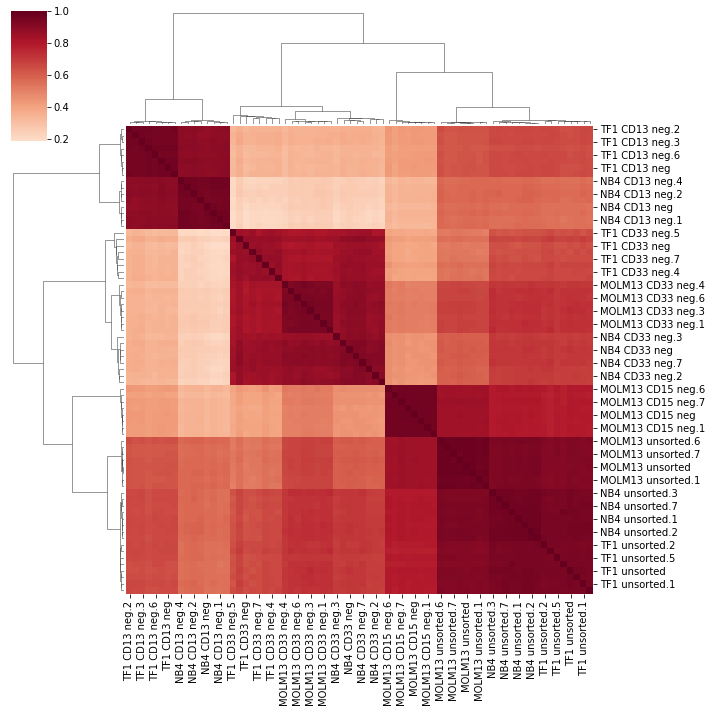

In [12]:
clean_human_reads = human_reads.copy()
clean_human_reads = clean_human_reads.drop(['Target', 
                                            'Position'], axis=1)
human_lognorms = pool.lognorm_columns(clean_human_reads, 
                                      clean_human_reads.columns[clean_human_reads.columns != 
                                                                'Sequence'])
human_lognorm_cors = human_lognorms.corr()
sns.clustermap(human_lognorm_cors, cmap='RdBu_r', center=0)


In [13]:
human_long_lognorms = (human_lognorms.melt(id_vars='Sequence', var_name='condition', 
                                           value_name='lognorm'))
human_long_lognorms['condition'] = human_long_lognorms['condition'].str.split('.', expand=True)[0]
human_avg_lognorms = (human_long_lognorms.groupby(['condition', 'Sequence'])
                      .agg({'lognorm': 'mean'})
                      .reset_index())
human_spread_lognorms = (human_avg_lognorms.pivot_table(values='lognorm', index='Sequence', 
                                                        columns='condition')
                         .reset_index())
human_filtered_lognorms = pool.filter_pdna(human_spread_lognorms, ['MOLM13 unsorted', 
                                                                   'NB4 unsorted', 
                                                                   'TF1 unsorted'])
human_lfcs = pool.calculate_lfcs(human_filtered_lognorms, ref_col='unsorted',
                                 ref_map={'MOLM13 CD15 neg': 'MOLM13 unsorted', 
                                          'MOLM13 CD33 neg': 'MOLM13 unsorted', 
                                          'NB4 CD13 neg': 'NB4 unsorted', 
                                          'NB4 CD33 neg': 'NB4 unsorted', 
                                          'TF1 CD13 neg': 'TF1 unsorted', 
                                          'TF1 CD33 neg': 'TF1 unsorted'})
human_long_lfcs = (human_lfcs.melt(id_vars='Sequence', var_name='condition', value_name='lfc'))

In [14]:
human_sg_list = list(human_lfcs['Sequence'].unique())
human_design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                                  filters=[[('sgRNA Sequence', 'in', human_sg_list)]])

In [15]:
human_lfcs_designs = (human_long_lfcs.rename({'Sequence': 'sgRNA Sequence'}, axis=1)
                      .merge(human_design_df, how = 'inner', on = 'sgRNA Sequence'))
human_lfcs_designs['neg_lfc'] = -human_lfcs_designs['lfc']
filtered_human_lfcs = human_lfcs_designs[human_lfcs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
human_genes = human_design_df['Target Gene Symbol'].unique()


In [16]:
human_expected_hits = {'MOLM13 CD15 neg': 'FUT4', 
                       'MOLM13 CD33 neg': 'CD33',
                       'NB4 CD33 neg': 'CD33', 
                       'TF1 CD33 neg': 'CD33', 
                       'NB4 CD13 neg': 'ANPEP', 
                       'TF1 CD13 neg': 'ANPEP'}
for cond, df in filtered_human_lfcs.groupby('condition'):
    expected_hit = human_expected_hits[cond]
    roc_aucs = pool.get_roc_aucs(lfcs=df, tp_genes=[expected_hit], 
                                 fp_genes=human_genes[human_genes != expected_hit], 
                                 gene_col='Target Gene Symbol', 
                                 score_col='neg_lfc', group_col='condition')
    print(roc_aucs)

         condition   ROC-AUC
0  MOLM13 CD15 neg  0.964713
         condition  ROC-AUC
0  MOLM13 CD33 neg  0.99407
      condition   ROC-AUC
0  NB4 CD13 neg  0.974932
      condition   ROC-AUC
0  NB4 CD33 neg  0.979696
      condition   ROC-AUC
0  TF1 CD13 neg  0.932599
      condition   ROC-AUC
0  TF1 CD33 neg  0.933713


In [17]:
human_model_df_list = []
for cond, df in filtered_human_lfcs.groupby('condition'):
    expected_hit = human_expected_hits[cond]
    tp_sgs = df[df['Target Gene Symbol'] == expected_hit].copy()
    tp_sgs['gene_rank'] = (tp_sgs
                           .lfc
                           .rank(pct=True, ascending=True))
    human_model_df_list.append(tp_sgs)
human_model_df = pd.concat(human_model_df_list)
human_avg_rank = (human_model_df.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                          'Target Cut %', 'On-Target Efficacy Score'])
                  .agg(avg_rank = ('gene_rank', 'mean'))
                  .reset_index())

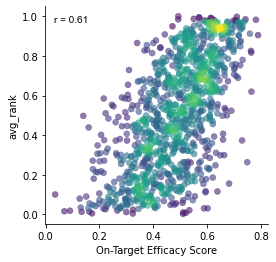

In [18]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=human_avg_rank, y='avg_rank', x='On-Target Efficacy Score')
gpplot.add_correlation(data=human_avg_rank, y='avg_rank', x='On-Target Efficacy Score')
sns.despine()

In [19]:
human_training_data = human_avg_rank.drop('On-Target Efficacy Score', axis=1)
human_training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_rank
0,AAATAATACCAACAACTGGA,TCAGAAATAATACCAACAACTGGAGGGAGA,ANPEP,76.4,0.753319
1,AAATTTCTGGCTGCAAGTGC,ATCCAAATTTCTGGCTGCAAGTGCAGGAGT,CD33,6.7,0.315369
2,AACAGCTCACTGATCTGGGC,GTCAAACAGCTCACTGATCTGGGCCGGCGT,ANPEP,48.1,0.686947
3,AACAGCTTGAGGTTTCAGTG,CCTGAACAGCTTGAGGTTTCAGTGGGGCCA,CD33,87.6,0.263473
4,AACCGCTGGACCCTGCAGAT,CATGAACCGCTGGACCCTGCAGATGGGCTT,ANPEP,56.4,0.366150
...,...,...,...,...,...
990,TTTCCTCGACCGCAACCCCG,TGCTTTTCCTCGACCGCAACCCCGCGGTCT,FUT4,90.1,0.688830
991,TTTCGAGAACTCGCAGCACC,TGGCTTTCGAGAACTCGCAGCACCTGGATT,FUT4,78.6,0.369681
992,TTTCTGAAGTGAATGAAGAG,ATTATTTCTGAAGTGAATGAAGAGGGGTGT,ANPEP,75.3,0.658186
993,TTTGACCGCTCCGAGGTCTA,CATGTTTGACCGCTCCGAGGTCTATGGCCC,ANPEP,73.7,0.130531


In [20]:
human_training_data.to_csv('../data/processed/Doench2014_human_activity.csv', index=False)